# Task 2A: Risk Rating

## Task Updates for Case Competition Final
- Apply stratified splits on training and test sets
- Apply SMOTE to address Class Imbalance issue
- Apply additional hyperparameter tuning
- Add Logistic and SVM models with SGD Training

## Problem Description
- Problem: there are too many clients in our customer database and heterogeneous, we would like
to automate this process to be as efficient and reliable as possible
- Ask: using predictive modelling classify all 1M customers into three risk buckets: **Low,
Medium and High**. As features, you must use KYC data and transactional data, your **target
variable is the risk rating provided**
- Diagram: ![task2_dia](task2_dia.png)

## Datasets
### Nodes Data
Description: main data source for this competition, contains KYC, Transactional data and Risk
Rating
- File name: UofT_nodes.csv -> df_origin -> **df_kyc**
- Number of Rows: 1M, one row per CUSTOMER_ID
- Number of Columns: 20 columns (1 target column); RISK = Target variable for Task 2

### Edges Data
Description: shows the connections between clients i.e. amount of money sent via EMT from
one customer (source) to another (target)
- File name: UofT_edges.csv
- Number of Rows: 466k

### Occupation Data
Description: lookup table that maps an occupation (code) to their risk level of being
involved in financial crimes
- File name: UofT_occupation_risk.csv
- Number of Rows: 841

## Exploratory Data Analysis
### Library

In [3]:
# Basic libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Statistic libraries
from scipy import stats
from scipy.stats import chi2_contingency

In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    url = '/content/drive//MyDrive/UofT_nodes.csv'
except:
    url = 'UofT_nodes.csv'

df = pd.read_csv(url,  dtype=str)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,BIRTH_DT,CUST_ADD_DT,OCPTN_NM,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,RISK,NAME,GENDER,CUSTOMER_ID
0,1981-09-01,2007-07-05,89.0,1,1,0.0,2577.785,2.0,2851.663,7.0,70774.0,62.0,24244.0,35.0,Low,Low,low,"Young, Marie Mildren Coleman",Female,935382.0
1,1994-02-21,2019-05-19,89.0,1,1,0.0,3035.502,2.0,4805.997,15.0,282929.0,76.0,196439.0,152.0,Low,Low,low,Mark Stupar Lecy,Male,2305.0
2,1962-11-16,2011-08-02,89.0,1,1,0.0,1617.5710000000001,1.0,3482.809,11.0,7632.0,6.0,33598.0,20.0,Low,Low,low,Dean Glasper Wendel Reeves,Male,472403.0
3,1998-06-20,2001-08-15,89.0,1,1,0.0,3587.042,5.0,1940.943,8.0,149253.0,71.0,105896.0,238.0,Low,Low,low,"Hulsey, Linda Rauth",Female,227994.0
4,1942-01-24,2012-10-28,89.0,1,1,0.0,1725.524,2.0,13197.169,43.0,92318.0,96.0,187403.0,180.0,Low,Low,low,Carolyn Washington Roberts,Female,418265.0


In [5]:
print('--------------View Columns--------------')
print('Number of Columns:', len(df.columns))
print(df.columns.tolist())
print('--------------NULL & NaN Check--------------')
for i in range(len(df.columns)):
    col = df.columns[i]
    if df[col].isnull().values.any():
        print(col, 'contains %d NULL' % df[col].isnull().values.sum())
    if df[col].values.dtype != 'O':
        if np.isnan(df[col].values).any():
            print(col, 'contains %d NaN' % np.isnan(df[col].values).sum())

--------------View Columns--------------
Number of Columns: 20
['BIRTH_DT', 'CUST_ADD_DT', 'OCPTN_NM', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RISK', 'NAME', 'GENDER', 'CUSTOMER_ID']
--------------NULL & NaN Check--------------
CUST_ADD_DT contains 4178 NULL
OCPTN_NM contains 6384 NULL
NAME contains 660 NULL
GENDER contains 628 NULL


## Machine Learning Models

## TOC:
* [Feature Selection](#feature-selection)
* [Resampling](#resampling)
* [Logistic Classifier](#logistic)
* [Random Forest](#randomforest)
* [Decision Tree](#decisiontree)
* [SGD](#sgd)


### Feature Selection <a class="anchor" id="feature-selection"></a>

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer, confusion_matrix

In [7]:
# Preprocess the node data
df = df.dropna(how='any', axis=0)
df['COUNTRY_RISK_INCOME'] = df['COUNTRY_RISK_INCOME'].astype('category').cat.codes
df['COUNTRY_RISK_RESIDENCY'] = df['COUNTRY_RISK_RESIDENCY'].astype('category').cat.codes
df['RISK'] = df['RISK'].replace(['low'], 0)
df['RISK'] = df['RISK'].replace(['medium'], 1)
df['RISK'] = df['RISK'].replace(['high'], 2)
df['GENDER'] = df['GENDER'].astype('category').cat.codes

# Convert string into numerical values for specific featrues
for i in range(2, 13):
  df.iloc[:, i] = df.iloc[:, i].astype(float)

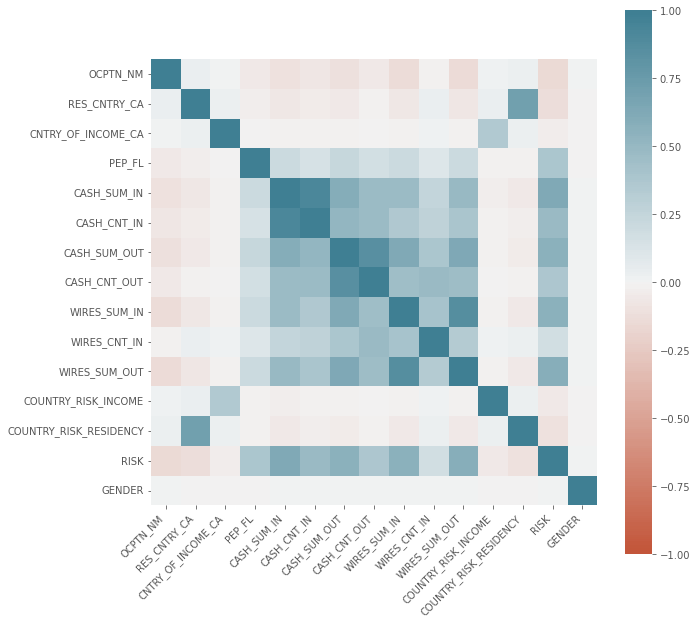

In [8]:
# Plot the correlations between features
corr = df.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

In [9]:
# Make a copy of new node data with only relevant features
feature = ['PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT']
df_new = df[feature + ['RISK']].copy()

In [10]:
# Split into train and test sets
X = df_new[feature]
y = df_new['RISK']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=40)

### Resampling <a class="anchor" id="resampling"></a>

In [11]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [ ]:
print("Original class distribution:")
print(pd.Series(y_train).value_counts())

Original class distribution:
0    415243
1    242307
2     34624
Name: RISK, dtype: int64


In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)
print("\nRandom oversampling class distribution:")
print(pd.Series(y_resampled_ros).value_counts())


Random oversampling class distribution:
0    415243
1    415243
2    415243
Name: RISK, dtype: int64


In [ ]:
rus = RandomUnderSampler(random_state=42)
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
print("\nRandom undersampling class distribution:")
print(pd.Series(y_resampled_rus).value_counts())


Random undersampling class distribution:
0    34624
1    34624
2    34624
Name: RISK, dtype: int64


In [ ]:
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)
print("\nSMOTE class distribution:")
print(pd.Series(y_resampled_smote).value_counts())


SMOTE class distribution:
0    415243
1    415243
2    415243
Name: RISK, dtype: int64


In [ ]:
smoteenn = SMOTEENN(random_state=42)
X_resampled_smoteenn, y_resampled_smoteenn = smoteenn.fit_resample(X_train, y_train)
print("\nSMOTEENN class distribution:")
print(pd.Series(y_resampled_smoteenn).value_counts())


SMOTEENN class distribution:
0    399015
2    380979
1    335839
Name: RISK, dtype: int64


### Logistic <a class="anchor" id="logistic"></a>

In [ ]:
# Find the best resampled dataset
def train_evaluate_logistic(X_train, y_train, X_test, y_test, title=""):
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit the model
    clf = LogisticRegression(multi_class='auto', solver='lbfgs')
    clf.fit(X_train, y_train)
    
    # Make prediction with test data
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{title}\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
    print(classification_report(y_test, y_pred))

train_evaluate_logistic(X_train, y_train, X_test, y_test, title="Original Data")
train_evaluate_logistic(X_resampled_ros, y_resampled_ros, X_test, y_test, title="Random Oversampling")
train_evaluate_logistic(X_resampled_rus, y_resampled_rus, X_test, y_test, title="Random Undersampling")
train_evaluate_logistic(X_resampled_smote, y_resampled_smote, X_test, y_test, title="SMOTE")
train_evaluate_logistic(X_resampled_smoteenn, y_resampled_smoteenn, X_test, y_test, title="SMOTEENN")

Original Data
Accuracy: 0.9504
F1-Score: 0.9406

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177961
           1       0.90      0.97      0.93    103846
           2       0.52      0.20      0.29     14839

    accuracy                           0.95    296646
   macro avg       0.81      0.73      0.74    296646
weighted avg       0.94      0.95      0.94    296646

Random Oversampling
Accuracy: 0.9086
F1-Score: 0.9229

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177961
           1       0.98      0.76      0.85    103846
           2       0.34      0.87      0.49     14839

    accuracy                           0.91    296646
   macro avg       0.77      0.88      0.78    296646
weighted avg       0.96      0.91      0.92    296646

Random Undersampling
Accuracy: 0.9089
F1-Score: 0.9230

              precision    recall  f1-score   support

           0       1.00

In [ ]:
# Find the best model/hyperparameter tuning
X_train_best = X_resampled_smote
y_train_best = y_resampled_smote

training_acc = []
validation_acc = []
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for param in c_range:
    clf = LogisticRegression(C=param ,multi_class='auto', solver='lbfgs')
    X_train_scaled = scaler.fit_transform(X_train_best)
    # Train the model with cross validation, using a 5-fold cross-validation
    scores = cross_validate(clf, X_train_scaled, y_train_best, cv=5, return_train_score=True)
    
    # Store the training and validation accuracy scores
    training_acc.append(scores['train_score'].mean())
    validation_acc.append(scores['test_score'].mean())

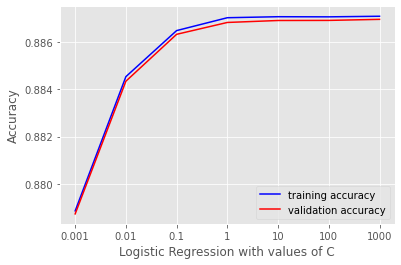

In [ ]:
# Find the best value of C
plt.figure()
plt.plot(list(map(str, c_range)),training_acc, c='blue',label='training accuracy')
plt.plot(list(map(str, c_range)),validation_acc, c='red',label='validation accuracy')
plt.xlabel('Logistic Regression with values of C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Best resampled data and logistic model
best_model = LogisticRegression(C=10, multi_class='auto', solver='lbfgs')
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train_best)

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

# Results from best resampled data and model
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.9117534030460549
precision: 0.9582566744620036
recall: 0.9117534030460549


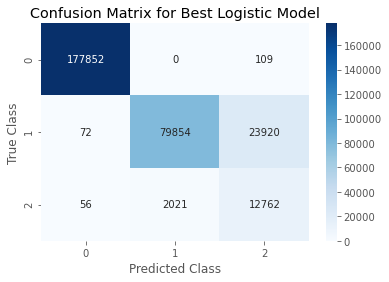

In [ ]:
# Plot confusion matrix
cm_log = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')

# Add labels to the plot
plt.title('Confusion Matrix for Best Logistic Model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

### RandomForest <a class="anchor" id="randomforest"></a>

In [ ]:
# Find the best resampled dataset
def train_evaluate_rf(X_train, y_train, X_test, y_test, title=""):
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit the model
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train, y_train)
    
    # Make prediction with test data
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{title}\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
    print(classification_report(y_test, y_pred))

train_evaluate_rf(X_train, y_train, X_test, y_test, title="Original Data")
train_evaluate_rf(X_resampled_ros, y_resampled_ros, X_test, y_test, title="Random Oversampling")
train_evaluate_rf(X_resampled_rus, y_resampled_rus, X_test, y_test, title="Random Undersampling")
train_evaluate_rf(X_resampled_smote, y_resampled_smote, X_test, y_test, title="SMOTE")
train_evaluate_rf(X_resampled_smoteenn, y_resampled_smoteenn, X_test, y_test, title="SMOTEENN")

Original Data
Accuracy: 1.0000
F1-Score: 1.0000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177961
           1       1.00      1.00      1.00    103846
           2       1.00      1.00      1.00     14839

    accuracy                           1.00    296646
   macro avg       1.00      1.00      1.00    296646
weighted avg       1.00      1.00      1.00    296646

Random Oversampling
Accuracy: 0.9537
F1-Score: 0.9491

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177961
           1       0.91      0.96      0.94    103846
           2       0.56      0.36      0.44     14839

    accuracy                           0.95    296646
   macro avg       0.83      0.77      0.79    296646
weighted avg       0.95      0.95      0.95    296646

Random Undersampling
Accuracy: 0.9143
F1-Score: 0.9275

              precision    recall  f1-score   support

           0       1.00

In [ ]:
# Find the best model/hyperparameter tuning
X_train_best = X_resampled_smote
y_train_best = y_resampled_smote

training_acc = []
validation_acc = []
max_depth_range = [int(x) for x in np.linspace(10, 100, num = 4)]
for param in max_depth_range:
    clf = RandomForestClassifier(max_depth=param, random_state=0)
    X_train_scaled = scaler.fit_transform(X_train_best)
    # Train the model with cross validation, using a 5-fold cross-validation
    scores = cross_validate(clf, X_train_scaled, y_train_best, cv=5, return_train_score=True)
    
    # Store the training and validation accuracy scores
    training_acc.append(scores['train_score'].mean())
    validation_acc.append(scores['test_score'].mean())

In [ ]:
# Best resampled data and RF model
best_model = RandomForestClassifier(max_depth=40, random_state=0)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train_best)

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

In [ ]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.9446815396128719
precision: 0.9535247686360768
recall: 0.9446815396128719


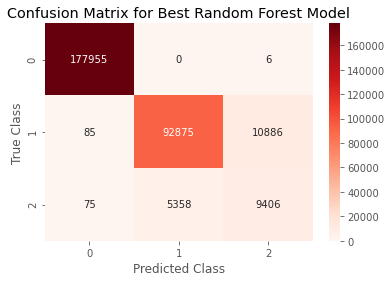

In [ ]:
# Plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds')

# Add labels to the plot
plt.title('Confusion Matrix for Best Random Forest Model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

### Decision Tree <a class="anchor" id="decisiontree"></a>

In [ ]:
# Find the best resampled dataset
def train_evaluate_dt(X_train, y_train, X_test, y_test, title=""):
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit the model
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)
    
    # Make prediction with test data
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{title}\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
    print(classification_report(y_test, y_pred))

train_evaluate_dt(X_train, y_train, X_test, y_test, title="Original Data")
train_evaluate_dt(X_resampled_ros, y_resampled_ros, X_test, y_test, title="Random Oversampling")
train_evaluate_dt(X_resampled_rus, y_resampled_rus, X_test, y_test, title="Random Undersampling")
train_evaluate_dt(X_resampled_smote, y_resampled_smote, X_test, y_test, title="SMOTE")
train_evaluate_dt(X_resampled_smoteenn, y_resampled_smoteenn, X_test, y_test, title="SMOTEENN")

Original Data
Accuracy: 0.9367
F1-Score: 0.9375

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177961
           1       0.91      0.91      0.91    103846
           2       0.38      0.40      0.39     14839

    accuracy                           0.94    296646
   macro avg       0.76      0.77      0.77    296646
weighted avg       0.94      0.94      0.94    296646

Random Oversampling
Accuracy: 0.9388
F1-Score: 0.9382

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177961
           1       0.91      0.92      0.91    103846
           2       0.39      0.37      0.38     14839

    accuracy                           0.94    296646
   macro avg       0.77      0.76      0.77    296646
weighted avg       0.94      0.94      0.94    296646

Random Undersampling
Accuracy: 0.9022
F1-Score: 0.9173

              precision    recall  f1-score   support

           0       1.00

In [ ]:
# Find the best model/hyperparameter tuning
X_train_best = X_resampled_smoteenn
y_train_best = y_resampled_smoteenn

training_acc_dt = []
validation_acc_dt = []
max_depth_num = []
min_samples_perc = []
for i in range(1, 32):
    for j in range(2,10):
        # Create a KNN classifier object
        clf = DecisionTreeClassifier(max_depth=i, min_samples_split=j, random_state=21)
        X_train_scaled = scaler.fit_transform(X_train_best)
        # Train the model with cross validation, using a 5-fold cross-validation
        scores = cross_validate(clf, X_train_scaled, y_train_best, cv=5, return_train_score=True)

        # Store the parameters training and validation accuracy scores
        max_depth_num.append(i)
        min_samples_perc.append(j)
        training_acc_dt.append(scores['train_score'].mean())
        validation_acc_dt.append(scores['test_score'].mean())

In [ ]:
# Best resampled data and DT model
best_model = DecisionTreeClassifier(max_depth=21, min_samples_split=2, random_state=0)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train_best)

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

In [ ]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.9180774391024993
precision: 0.9549750640688291
recall: 0.9180774391024993


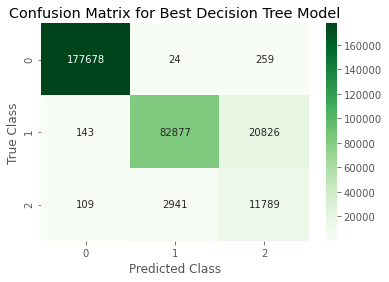

In [ ]:
# Plot confusion matrix
cm_dt = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens')

# Add labels to the plot
plt.title('Confusion Matrix for Best Decision Tree Model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

### SGD <a class="anchor" id="sgd"></a>
#### Logistic Regression with SGD Training

In [ ]:
# Find the best resampled dataset
def train_evaluate_sgd_log(X_train, y_train, X_test, y_test, title=""):
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit the model
    clf = SGDClassifier(loss="log", penalty="l2")
    clf.fit(X_train, y_train)
    
    # Make prediction with test data
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{title}\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
    print(classification_report(y_test, y_pred))

train_evaluate_sgd_log(X_train, y_train, X_test, y_test, title="Original Data")
train_evaluate_sgd_log(X_resampled_ros, y_resampled_ros, X_test, y_test, title="Random Oversampling")
train_evaluate_sgd_log(X_resampled_rus, y_resampled_rus, X_test, y_test, title="Random Undersampling")
train_evaluate_sgd_log(X_resampled_smote, y_resampled_smote, X_test, y_test, title="SMOTE")
train_evaluate_sgd_log(X_resampled_smoteenn, y_resampled_smoteenn, X_test, y_test, title="SMOTEENN")

Original Data
Accuracy: 0.9459
F1-Score: 0.9287

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    177961
           1       0.89      0.98      0.93    103846
           2       0.52      0.08      0.13     14839

    accuracy                           0.95    296646
   macro avg       0.80      0.68      0.69    296646
weighted avg       0.93      0.95      0.93    296646

Random Oversampling
Accuracy: 0.9161
F1-Score: 0.9273

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    177961
           1       0.96      0.79      0.87    103846
           2       0.35      0.77      0.48     14839

    accuracy                           0.92    296646
   macro avg       0.77      0.85      0.78    296646
weighted avg       0.95      0.92      0.93    296646

Random Undersampling
Accuracy: 0.9174
F1-Score: 0.9283

              precision    recall  f1-score   support

           0       1.00

In [ ]:
# Find the best model/hyperparameter tuning
X_train_best = X_resampled_rus
y_train_best = y_resampled_rus

training_acc = []
validation_acc = []
n_iters = [5, 10, 20, 50, 100, 1000]
for param in n_iters:
    clf = SGDClassifier(loss="log", penalty="l2", max_iter=param)
    X_train_scaled = scaler.fit_transform(X_train_best)
    # Train the model with cross validation, using a 5-fold cross-validation
    scores = cross_validate(clf, X_train_scaled, y_train_best, cv=5, return_train_score=True)
    
    # Store the training and validation accuracy scores
    training_acc.append(scores['train_score'].mean())
    validation_acc.append(scores['test_score'].mean())

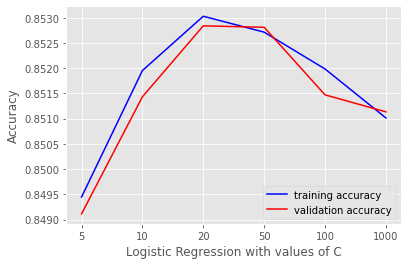

In [ ]:
# Find the best value of max_iter
plt.figure()
plt.plot(list(map(str, n_iters)),training_acc, c='blue',label='training accuracy')
plt.plot(list(map(str, n_iters)),validation_acc, c='red',label='validation accuracy')
plt.xlabel('Logistic Regression with values of C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Best resampled data and logistic model
best_model = SGDClassifier(loss="log", penalty="l2", max_iter=20)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train_best)

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

# Results from best resampled data and model
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.920666383500873
precision: 0.9510406238885094
recall: 0.920666383500873


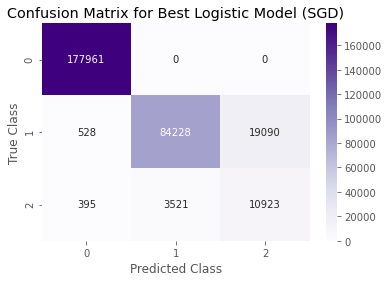

In [ ]:
# Plot confusion matrix
cm_log_sgd = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_log_sgd, annot=True, fmt='d', cmap='Purples')

# Add labels to the plot
plt.title('Confusion Matrix for Best Logistic Model (SGD)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

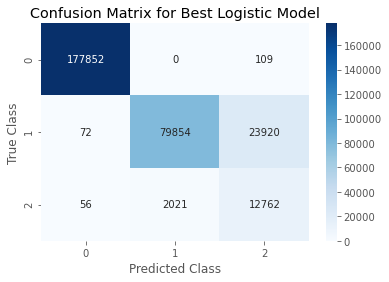

In [ ]:
# Compare with previous logistic model
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Logistic Model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

#### Linear SVM with SGD Training

In [ ]:
# Find the best resampled dataset
def train_evaluate_sgd_svm(X_train, y_train, X_test, y_test, title=""):
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit the model
    clf = SGDClassifier(loss="hinge", penalty="l2")
    clf.fit(X_train, y_train)
    
    # Make prediction with test data
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{title}\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
    print(classification_report(y_test, y_pred))

train_evaluate_sgd_svm(X_train, y_train, X_test, y_test, title="Original Data")
train_evaluate_sgd_svm(X_resampled_ros, y_resampled_ros, X_test, y_test, title="Random Oversampling")
train_evaluate_sgd_svm(X_resampled_rus, y_resampled_rus, X_test, y_test, title="Random Undersampling")
train_evaluate_sgd_svm(X_resampled_smote, y_resampled_smote, X_test, y_test, title="SMOTE")
train_evaluate_sgd_svm(X_resampled_smoteenn, y_resampled_smoteenn, X_test, y_test, title="SMOTEENN")

Original Data
Accuracy: 0.9482
F1-Score: 0.9279

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    177961
           1       0.88      0.99      0.93    103846
           2       0.56      0.04      0.07     14839

    accuracy                           0.95    296646
   macro avg       0.81      0.68      0.67    296646
weighted avg       0.93      0.95      0.93    296646

Random Oversampling
Accuracy: 0.9099
F1-Score: 0.9226

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177961
           1       0.96      0.78      0.86    103846
           2       0.33      0.75      0.46     14839

    accuracy                           0.91    296646
   macro avg       0.76      0.84      0.77    296646
weighted avg       0.95      0.91      0.92    296646

Random Undersampling
Accuracy: 0.9073
F1-Score: 0.9208

              precision    recall  f1-score   support

           0       1.00

In [ ]:
# Find the best model/hyperparameter tuning
X_train_best = X_resampled_ros
y_train_best = y_resampled_ros

training_acc = []
validation_acc = []
n_iters = [5, 10, 20, 50, 100, 1000]
for param in n_iters:
    clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=param)
    X_train_scaled = scaler.fit_transform(X_train_best)
    # Train the model with cross validation, using a 5-fold cross-validation
    scores = cross_validate(clf, X_train_scaled, y_train_best, cv=5, return_train_score=True)
    
    # Store the training and validation accuracy scores
    training_acc.append(scores['train_score'].mean())
    validation_acc.append(scores['test_score'].mean())

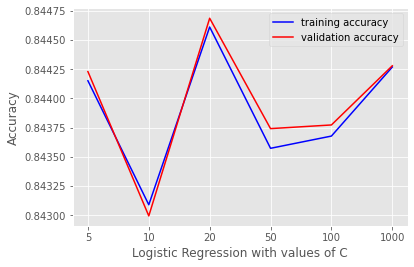

In [ ]:
# Find the best value of max_iter
plt.figure()
plt.plot(list(map(str, n_iters)),training_acc, c='blue',label='training accuracy')
plt.plot(list(map(str, n_iters)),validation_acc, c='red',label='validation accuracy')
plt.xlabel('Logistic Regression with values of C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Best resampled data and svm model
best_model = SGDClassifier(loss="hinge", penalty="l2", max_iter=20)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train_best)

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

# Results from best resampled data and model
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.912579303277307
precision: 0.9500658055840759
recall: 0.912579303277307


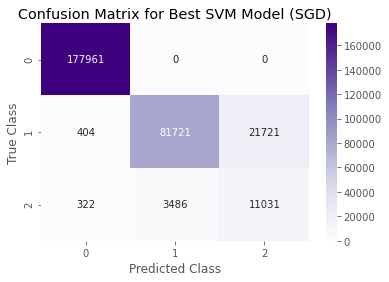

In [ ]:
# Plot confusion matrix
cm_svm_sgd = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_svm_sgd, annot=True, fmt='d', cmap='Purples')

# Add labels to the plot
plt.title('Confusion Matrix for Best SVM Model (SGD)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

### Gradient Boost

In [17]:
gbm = GradientBoostingClassifier(n_estimators=200, random_state=42)
gbm.fit(X_train_smoteenn, y_train_smoteenn)
y_pred = gbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.9263
F1-Score: 0.9364

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118811
           1       0.98      0.81      0.89     69086
           2       0.39      0.86      0.54      9867

    accuracy                           0.93    197764
   macro avg       0.79      0.89      0.81    197764
weighted avg       0.96      0.93      0.94    197764



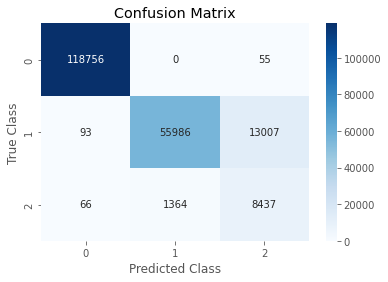

In [18]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

## Model Performance Summary
| Model          | Accuracy | Precision | Recall  |
|----------------|----------|-----------|---------|
| Logistic       | 0.91175  | 0.95826   | 0.91175 |
| Random Forest  | 0.94468  | 0.95352   | 0.94468 |
| Decision Tree  | 0.91807  | 0.95498   | 0.91808 |
| Logistic (SGD) | 0.92067  | 0.95104   | 0.92067 |
| SVM (SGD)      | 0.91258  | 0.95007   | 0.91258 |

## Best Model -- RandomForest

In [12]:
X = df_new[feature]
y = df_new['RISK']

In [13]:
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_smoteenn, y_train_smoteenn)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.9558
F1-Score: 0.9605

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118811
           1       0.99      0.88      0.93     69086
           2       0.54      0.93      0.68      9867

    accuracy                           0.96    197764
   macro avg       0.84      0.94      0.87    197764
weighted avg       0.97      0.96      0.96    197764



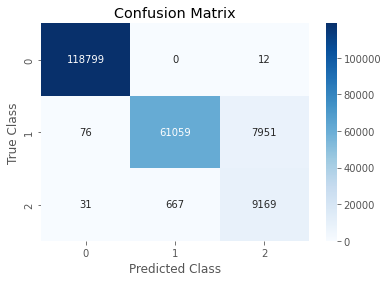

In [14]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()